### **Step 1:** Get the Data

In [5]:
from fredapi import Fred
import os
from dotenv import load_dotenv

load_dotenv()

fred = Fred(api_key=os.getenv("FRED_API_KEY"))

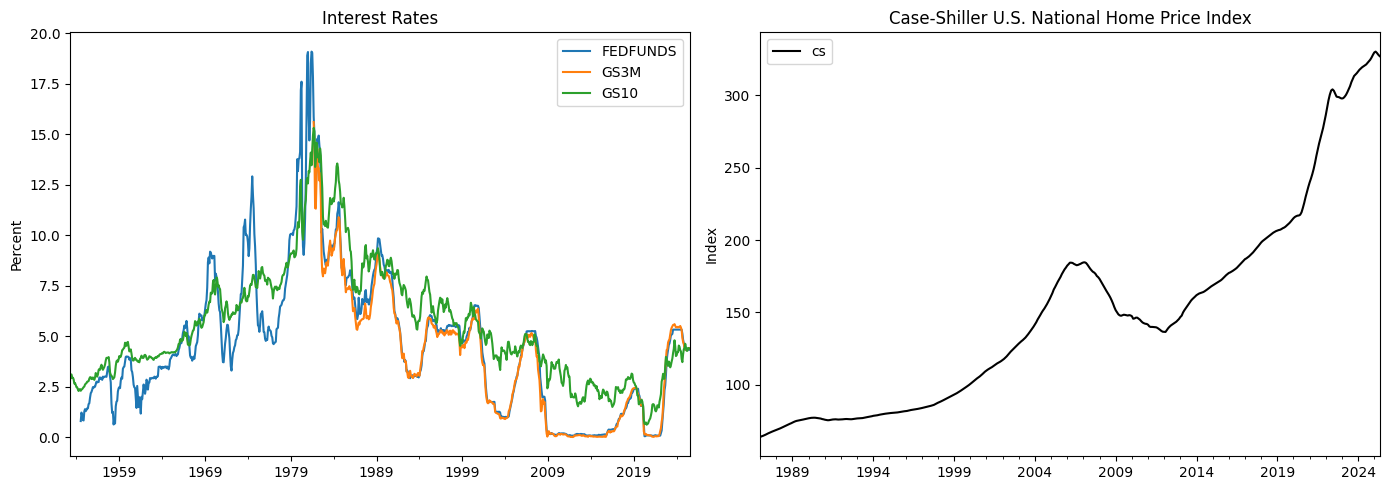

In [24]:
from matplotlib import pyplot as plt

ff = fred.get_series("FEDFUNDS")
rate_3mo = fred.get_series("GS3M")
rate_10y = fred.get_series("GS10")
cs = fred.get_series("CSUSHPISA").dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ff.plot(ax=ax1, label="FEDFUNDS")
rate_3mo.plot(ax=ax1, label="GS3M")
rate_10y.plot(ax=ax1, label="GS10")
ax1.set_title("Interest Rates")
ax1.set_ylabel("Percent")
ax1.legend()

cs.plot(ax=ax2, label="cs", color="black")
ax2.set_title("Case-Shiller U.S. National Home Price Index")
ax2.set_ylabel("Index")
ax2.legend()

plt.tight_layout()
plt.show()

### **Step 2:** Preprocessing

In [32]:
import pandas as pd
import numpy as np

df = pd.DataFrame({
    "ff": ff,
    "rate_3mo": rate_3mo,
    "rate_10y": rate_10y,
    "cs": cs
})

df = df.interpolate("linear").dropna()
df.cs = np.log(df.cs)
df = df.diff(1).dropna()

df

,ff,rate_3mo,rate_10y,cs
1987-02-01,-0.33,0.17,0.17,0.007135
1987-03-01,0.03,0.02,0.00,0.004847
1987-04-01,0.24,0.05,0.77,0.006099
1987-05-01,0.48,0.03,0.59,0.006596
1987-06-01,-0.12,0.00,-0.21,0.007719
...,...,...,...,...
2025-03-01,0.00,0.01,-0.17,-0.002842
2025-04-01,0.00,-0.02,0.00,-0.003744
2025-05-01,0.00,0.04,0.14,-0.002910
2025-06-01,0.00,0.06,-0.04,0.000000


### **Step 3:** Analyze FF Rate and Short-Term Rate Relationship

In [57]:
import statsmodels.api as sm

sorted_idxs = df.ff.argsort()

y = df.rate_3mo.values[sorted_idxs]
x = df.ff.values[sorted_idxs]
X = sm.add_constant(x)

model = sm.OLS(y, X)
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.564
Model:                            OLS   Adj. R-squared:                  0.563
Method:                 Least Squares   F-statistic:                     595.4
Date:                Fri, 08 Aug 2025   Prob (F-statistic):           5.49e-85
Time:                        10:27:16   Log-Likelihood:                 282.93
No. Observations:                 462   AIC:                            -561.9
Df Residuals:                     460   BIC:                            -553.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010      0.006      0.168      0.8

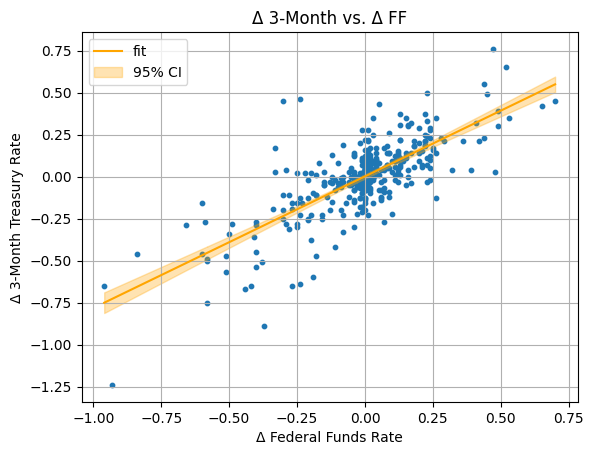

In [59]:
preds = results.get_prediction(X)
pred_summary = preds.summary_frame(alpha=0.05)

plt.scatter(x, y, s=10)
plt.plot(x, pred_summary["mean"], color="orange", label="fit")
plt.fill_between(
    x,
    pred_summary["mean_ci_lower"],
    pred_summary["mean_ci_upper"],
    color="orange",
    alpha=0.3,
    label="95% CI"
)
plt.xlabel("Δ Federal Funds Rate")
plt.ylabel("Δ 3-Month Treasury Rate")
plt.title("Δ 3-Month vs. Δ FF")
plt.grid()
plt.legend()
plt.show()

### **Step 4:** Analyze Short and Long Term Rate Relationship

In [63]:
import statsmodels.api as sm

# Add 1-period lag of 3mo rate
df['rate_3mo_lag1'] = df['rate_3mo'].shift(1)

# Drop rows with NaNs (from lag)
df_clean = df.dropna(subset=['rate_3mo', 'rate_3mo_lag1', 'rate_10y'])

# Define predictors and response
X = df_clean[['rate_3mo', 'rate_3mo_lag1']]
X = sm.add_constant(X)
y = df_clean['rate_10y']

# Fit OLS model
model = sm.OLS(y, X)
results = model.fit()

print(results.summary())


                            OLS Regression Results                            
Dep. Variable:               rate_10y   R-squared:                       0.176
Model:                            OLS   Adj. R-squared:                  0.173
Method:                 Least Squares   F-statistic:                     49.00
Date:                Fri, 08 Aug 2025   Prob (F-statistic):           5.22e-20
Time:                        10:33:14   Log-Likelihood:                 70.899
No. Observations:                 461   AIC:                            -135.8
Df Residuals:                     458   BIC:                            -123.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0050      0.010     -0.514

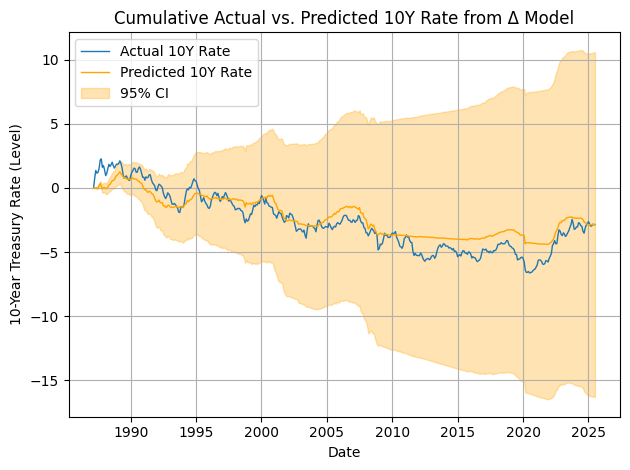

In [ ]:
# Get prediction summary
preds = results.get_prediction(X)
pred_summary = preds.summary_frame(alpha=0.05)

# Get aligned time index
time_index = df_clean.index

# Reconstruct level series by cumulative sum
# You need a starting value (e.g. first observed 10y rate)
start_value = df_clean['rate_10y'].iloc[0]

# Actual cumulative: from actual changes
actual_cum = np.cumsum(y) + start_value

# Predicted cumulative: from predicted changes
pred_cum = np.cumsum(pred_summary["mean"]) + start_value
lower_cum = np.cumsum(pred_summary["mean_ci_lower"]) + start_value
upper_cum = np.cumsum(pred_summary["mean_ci_upper"]) + start_value

# Plot
plt.plot(time_index, actual_cum, label="Actual 10Y Rate", linewidth=1)
plt.plot(time_index, pred_cum, label="Predicted 10Y Rate", color="orange", linewidth=1)

# Confidence band
plt.fill_between(
    time_index,
    lower_cum,
    upper_cum,
    color="orange",
    alpha=0.3,
    label="95% CI"
)

plt.xlabel("Date")
plt.ylabel("10-Year Treasury Rate (Level)")
plt.title("Cumulative Actual vs. Predicted 10Y Rate from Δ Model")
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()
